<a href="https://colab.research.google.com/github/jrgreen7/SYSC4906/blob/master/Lecture_9a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture9 Notebook

Based on Jose Portilla's excellent tutorial at https://www.springboard.com/blog/beginners-guide-neural-network-in-python-scikit-learn-0-18/

## Goal:
Use the UCI ML Repository's "wine" dataset (https://archive.ics.uci.edu/ml/datasets/Wine) to illustrate a feed-forward neural network with 1 input layer, 3 hidden layers (13 nodes each), and 1 output layer (single logit node)?? The goal is to guess the "cultivar" of each wine, based on 13 chemical properties of each bottle.

## Step 1: Load the data, split it, scale it


In [0]:
#import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

wine = load_wine(return_X_y = False);

list(wine.target_names)
list(wine.feature_names)

X = wine.data  # 13 features, 178 samples
y = wine.target

# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Scale the feature data. Learn scale (normalization) parameters from the training data, but apply to both train and test data
scaler = StandardScaler()

scaler.fit(X_train) # Learn the scaling parameters only from the train data

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


## Step 2: Create the classifier, train, test

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

# Create a neural network. Only specify the number of hidden layers, the activation function, and the maximum number of training iterations (epochs?). Many other parameters are available... see docs
#act = 'relu'
act = 'logistic'
h_layer_sizes = list(); h_layer_sizes.append(5)
mlp = MLPClassifier(hidden_layer_sizes=h_layer_sizes,max_iter=500, activation=act)

# Train the model from scaled training data:
mlp.fit(X_train,y_train)

# Make some predictions from the (scaled) test data:
predictions = mlp.predict(X_test)

# Quantify accuracy using a confusion matrix (3 wine "classes")
print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

[[12  0  0]
 [ 1 19  0]
 [ 0  0 13]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.95      0.97        20
           2       1.00      1.00      1.00        13

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [21]:
# We can also dig into the model's learned parameters/weights:

#coefs_ is a list of weight matrices, where weight matrix at index i represents the weights between layer i and layer i+1.
print('The number of hidden layers, including the input layer, is ', len(mlp.coefs_))
print('The number of connection weights between the input layer and the first hidden layer is ', len(mlp.coefs_[0]))

#intercepts_ is a list of bias vectors, where the vector at index i represents the bias values added to layer i+1.
print('The number of bias weights incident on layer 2 (i.e. the output layer) is ', len(mlp.intercepts_[1]))



The number of hidden layers, including the input layer, is  2
The number of connection weights between the input layer and the first hidden layer is  13
The number of bias weights incident on layer 2 (i.e. the output layer) is  3


## Visualize the trained network
Using visualization library from https://github.com/jzliu-100/visualize-neural-network

In [0]:
# This Libraray is modified based the work by Milo Spencer-Harper and Oli Blum, https://stackoverflow.com/a/37366154/10404826
# On top of that, I added support for showing weights (linewidth, colors, etc.)
# Contributor: Jianzheng Liu
# Contact: jzliu.100@gmail.com

from matplotlib import pyplot
from math import cos, sin, atan
from palettable.tableau import Tableau_10
from time import localtime, strftime
import numpy as np

class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius, id=-1):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)
        pyplot.gca().text(self.x, self.y-0.15, str(id), size=10, ha='center')

class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, weight=0.4, textoverlaphandler=None):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)

        # assign colors to lines depending on the sign of the weight
        color=Tableau_10.mpl_colors[0]
        if weight > 0: color=Tableau_10.mpl_colors[1]

        # assign different linewidths to lines depending on the size of the weight
        abs_weight = abs(weight)        
        if abs_weight > 0.5: 
            linewidth = 10*abs_weight
        elif abs_weight > 0.8: 
            linewidth =  100*abs_weight
        else:
            linewidth = abs_weight

        # draw the weights and adjust the labels of weights to avoid overlapping
        if abs_weight > 0.5: 
            # while loop to determine the optimal locaton for text lables to avoid overlapping
            index_step = 2
            num_segments = 10   
            txt_x_pos = neuron1.x - x_adjustment+index_step*(neuron2.x-neuron1.x+2*x_adjustment)/num_segments
            txt_y_pos = neuron1.y - y_adjustment+index_step*(neuron2.y-neuron1.y+2*y_adjustment)/num_segments
            while ((not textoverlaphandler.getspace([txt_x_pos-0.5, txt_y_pos-0.5, txt_x_pos+0.5, txt_y_pos+0.5])) and index_step < num_segments):
                index_step = index_step + 1
                txt_x_pos = neuron1.x - x_adjustment+index_step*(neuron2.x-neuron1.x+2*x_adjustment)/num_segments
                txt_y_pos = neuron1.y - y_adjustment+index_step*(neuron2.y-neuron1.y+2*y_adjustment)/num_segments

            # print("Label positions: ", "{:.2f}".format(txt_x_pos), "{:.2f}".format(txt_y_pos), "{:3.2f}".format(weight))
            a=pyplot.gca().text(txt_x_pos, txt_y_pos, "{:3.2f}".format(weight), size=8, ha='center')
            a.set_bbox(dict(facecolor='white', alpha=0))
            # print(a.get_bbox_patch().get_height())

        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment), linewidth=linewidth, color=color)
        pyplot.gca().add_line(line)

    def draw(self, layerType=0, weights=None, textoverlaphandler=None):
        j=0 # index for neurons in this layer
        for neuron in self.neurons:            
            i=0 # index for neurons in previous layer
            neuron.draw( self.neuron_radius, id=j+1 )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weights[i,j], textoverlaphandler)
                    i=i+1
            j=j+1
        
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

# A class to handle Text Overlapping
# The idea is to first create a grid space, if a grid is already occupied, then
# the grid is not available for text labels.
class TextOverlappingHandler():
    # initialize the class with the width and height of the plot area
    def __init__(self, width, height, grid_size=0.2):
        self.grid_size = grid_size
        self.cells = np.ones((int(np.ceil(width / grid_size)), int(np.ceil(height / grid_size))), dtype=bool)

    # input test_coordinates(bottom left and top right), 
    # getspace will tell you whether a text label can be put in the test coordinates
    def getspace(self, test_coordinates):
        x_left_pos = int(np.floor(test_coordinates[0]/self.grid_size))
        y_botttom_pos = int(np.floor(test_coordinates[1]/self.grid_size))
        x_right_pos = int(np.floor(test_coordinates[2]/self.grid_size))
        y_top_pos = int(np.floor(test_coordinates[3]/self.grid_size))
        if self.cells[x_left_pos, y_botttom_pos] and self.cells[x_left_pos, y_top_pos] \
        and self.cells[x_right_pos, y_top_pos] and self.cells[x_right_pos, y_botttom_pos]:
            for i in range(x_left_pos, x_right_pos):
                for j in range(y_botttom_pos, y_top_pos):
                    self.cells[i, j] = False

            return True
        else:
            return False

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self, weights_list=None):
        # vertical_distance_between_layers and horizontal_distance_between_neurons are the same with the variables of the same name in layer class
        vertical_distance_between_layers = 6
        horizontal_distance_between_neurons = 2
        overlaphandler = TextOverlappingHandler(\
            self.number_of_neurons_in_widest_layer*horizontal_distance_between_neurons,\
            len(self.layers)*vertical_distance_between_layers, grid_size=0.2 )

        pyplot.figure(figsize=(12, 9))
        for i in range( len(self.layers) ):
            layer = self.layers[i]                                
            if i == 0:
                layer.draw( layerType=0 )
            elif i == len(self.layers)-1:
                layer.draw( layerType=-1, weights=weights_list[i-1], textoverlaphandler=overlaphandler)
            else:
                layer.draw( layerType=i, weights=weights_list[i-1], textoverlaphandler=overlaphandler)

        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        figureName='ANN_'+strftime("%Y%m%d_%H%M%S", localtime())+'.png'
        pyplot.savefig(figureName, dpi=300, bbox_inches="tight")
        pyplot.show()

class DrawNN():
    # para: neural_network is an array of the number of neurons 
    # from input layer to output layer, e.g., a neural network of 5 nerons in the input layer, 
    # 10 neurons in the hidden layer 1 and 1 neuron in the output layer is [5, 10, 1]
    # para: weights_list (optional) is the output weights list of a neural network which can be obtained via classifier.coefs_
    def __init__( self, neural_network, weights_list=None ):
        self.neural_network = neural_network
        self.weights_list = weights_list
        # if weights_list is none, then create a uniform list to fill the weights_list
        if weights_list is None:
            weights_list=[]
            for first, second in zip(neural_network, neural_network[1:]):
                tempArr = np.ones((first, second))*0.4
                weights_list.append(tempArr)
            self.weights_list = weights_list
        
    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw(self.weights_list)

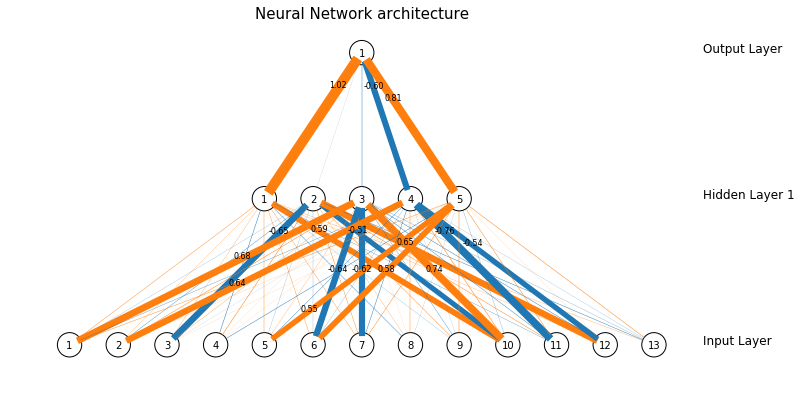

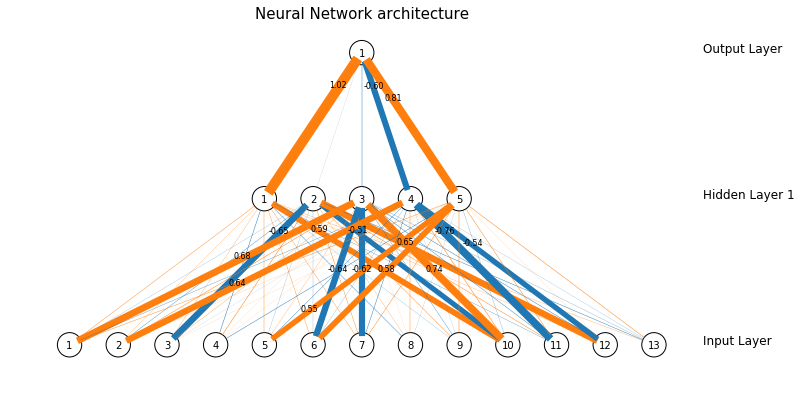

In [38]:
# Visualize the trained network
network_structure = np.hstack(([X.shape[1]], np.asarray(mlp.hidden_layer_sizes), 1))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_)
network.draw()